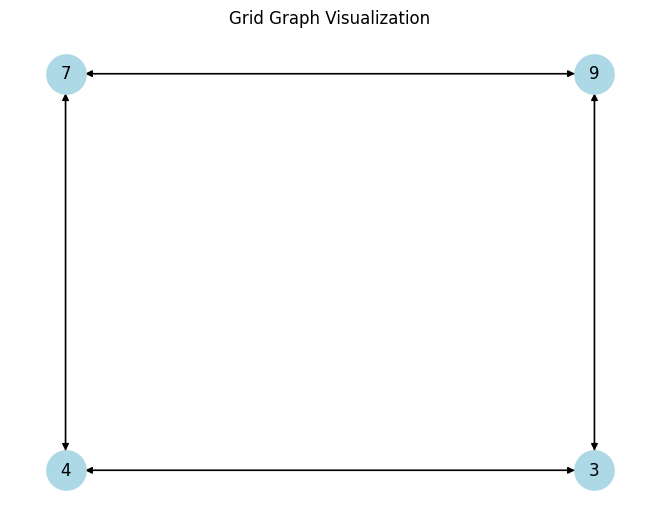

In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

def make_grid_graph(grid):
    rows, cols = len(grid), len(grid[0])
    edge_index = []
    node_features = []

    node_id_map = {}
    idx = 0
    for y in range(rows):
        for x in range(cols):
            node_features.append([x, y, grid[y][x]])
            node_id_map[(x, y)] = idx
            idx += 1

    for y in range(rows):
        for x in range(cols):
            src = node_id_map[(x, y)]
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx_, ny_ = x + dx, y + dy
                if 0 <= nx_ < cols and 0 <= ny_ < rows:
                    dst = node_id_map[(nx_, ny_)]
                    edge_index.append([src, dst])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index)

def visualize_grid_graph(data):
    G = nx.DiGraph()
    for i, (x, y, val) in enumerate(data.x.tolist()):
        G.add_node(i, pos=(x, -y), label=str(int(val)))
    edge_list = data.edge_index.t().tolist()
    G.add_edges_from(edge_list)
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color='lightblue')
    plt.title("Grid Graph Visualization")
    plt.show()

# Run this
input_grid = [[7, 9], [4, 3]]
graph = make_grid_graph(input_grid)
visualize_grid_graph(graph)


In [2]:
def extract_tile(data, tile_width=2, tile_height=2):
    """
    Extracts a tile from the top-left corner of the graph.
    Assumes all nodes have x, y, value as features.
    Returns a list of (dx, dy, value) relative to top-left.
    """
    tile_nodes = []
    for node in data.x:
        x, y, val = int(node[0]), int(node[1]), int(node[2])
        if x < tile_width and y < tile_height:
            tile_nodes.append((x, y, val))
    
    # Normalize positions to (0, 0)
    tile_pattern = [(x, y, val) for (x, y, val) in sorted(tile_nodes)]
    return tile_pattern

tile = extract_tile(graph)
print("Extracted Tile:")
for entry in tile:
    print(entry)


Extracted Tile:
(0, 0, 7)
(0, 1, 4)
(1, 0, 9)
(1, 1, 3)


In [3]:
def apply_tile_pattern(tile, width=6, height=6):
    """
    Repeat the 2×2 `tile` over a 6×6 grid in a 3×3 layout,
    flipping horizontally on each odd row-block.
    `tile` is a list of (dx, dy, value) for dx,dy in {0,1}.
    """
    output = [[0]*width for _ in range(height)]
    tile_w, tile_h = 2, 2

    for tile_row in range(height // tile_h):
        flip_h = (tile_row % 2 == 1)    # flip on rows 2–3, 6–7, …
        for tile_col in range(width // tile_w):
            for dx, dy, val in tile:
                x = (tile_w - 1 - dx) if flip_h else dx
                y = dy
                out_x = tile_col * tile_w + x
                out_y = tile_row * tile_h + y
                output[out_y][out_x] = val

    return output

# Example usage:
tile = [(0,0,7), (1,0,9), (0,1,4), (1,1,3)]
grid = apply_tile_pattern(tile)
for row in grid:
    print(row)


[7, 9, 7, 9, 7, 9]
[4, 3, 4, 3, 4, 3]
[9, 7, 9, 7, 9, 7]
[3, 4, 3, 4, 3, 4]
[7, 9, 7, 9, 7, 9]
[4, 3, 4, 3, 4, 3]


Output node features (x,y,value):
[[0.0, 0.0, 7.0], [1.0, 0.0, 9.0], [2.0, 0.0, 7.0], [3.0, 0.0, 9.0], [4.0, 0.0, 7.0], [5.0, 0.0, 9.0], [0.0, 1.0, 4.0], [1.0, 1.0, 3.0], [2.0, 1.0, 4.0], [3.0, 1.0, 3.0], [4.0, 1.0, 4.0], [5.0, 1.0, 3.0], [0.0, 2.0, 9.0], [1.0, 2.0, 7.0], [2.0, 2.0, 9.0], [3.0, 2.0, 7.0], [4.0, 2.0, 9.0], [5.0, 2.0, 7.0], [0.0, 3.0, 3.0], [1.0, 3.0, 4.0], [2.0, 3.0, 3.0], [3.0, 3.0, 4.0], [4.0, 3.0, 3.0], [5.0, 3.0, 4.0], [0.0, 4.0, 7.0], [1.0, 4.0, 9.0], [2.0, 4.0, 7.0], [3.0, 4.0, 9.0], [4.0, 4.0, 7.0], [5.0, 4.0, 9.0], [0.0, 5.0, 4.0], [1.0, 5.0, 3.0], [2.0, 5.0, 4.0], [3.0, 5.0, 3.0], [4.0, 5.0, 4.0], [5.0, 5.0, 3.0]]
Number of edges: 120


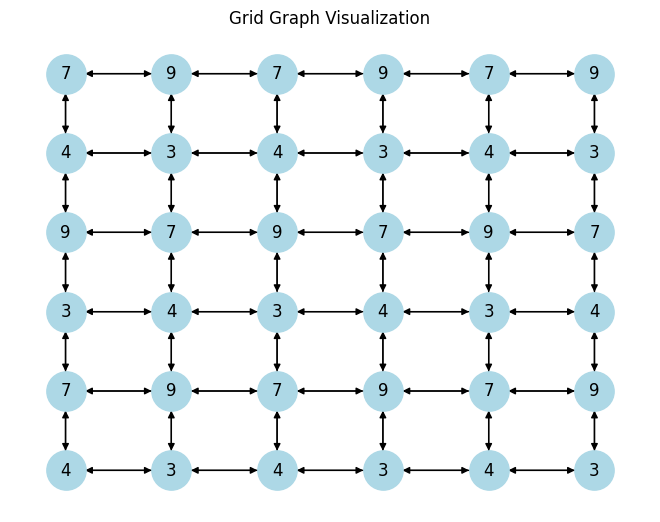

In [4]:
import torch
from torch_geometric.data import Data

def make_grid_graph(grid):
    """Same as before: grid (list of lists) → PyG Data."""
    rows, cols = len(grid), len(grid[0])
    edge_index, node_feats = [], []
    node_id = {}
    idx = 0
    for y in range(rows):
        for x in range(cols):
            node_feats.append([x, y, grid[y][x]])
            node_id[(x, y)] = idx
            idx += 1
    for y in range(rows):
        for x in range(cols):
            src = node_id[(x, y)]
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                nx_, ny_ = x+dx, y+dy
                if 0 <= nx_ < cols and 0 <= ny_ < rows:
                    edge_index.append([src, node_id[(nx_,ny_)]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_feats, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def extract_tile(data, tile_w=2, tile_h=2):
    """Pull out the top-left tile as (dx,dy,value) list."""
    tile = []
    for feat in data.x.tolist():
        x, y, val = map(int, feat)
        if x < tile_w and y < tile_h:
            tile.append((x, y, val))
    return sorted(tile)

def apply_tile_pattern(tile, width=6, height=6, tile_w=2, tile_h=2):
    """Repeat+flip logic → returns a 2D Python list (the new grid)."""
    out = [[0]*width for _ in range(height)]
    for block_row in range(height//tile_h):
        flip_h = (block_row % 2 == 1)
        for block_col in range(width//tile_w):
            for dx, dy, val in tile:
                x = (tile_w-1 - dx) if flip_h else dx
                y = dy
                out_y = block_row*tile_h + y
                out_x = block_col*tile_w + x
                out[out_y][out_x] = val
    return out

def transform_graph(input_data):
    """Full pipeline: Data → Data′ for the 6×6 output."""
    tile = extract_tile(input_data, tile_w=2, tile_h=2)
    output_grid = apply_tile_pattern(tile, width=6, height=6, tile_w=2, tile_h=2)
    return make_grid_graph(output_grid)

# Example usage:
input_grid = [[7,9],[4,3]]
input_data = make_grid_graph(input_grid)
output_data = transform_graph(input_data)

print("Output node features (x,y,value):")
print(output_data.x.tolist())
print("Number of edges:", output_data.edge_index.size(1))
visualize_grid_graph(output_data)

In [5]:
def graph_to_grid(data):
    """
    Converts a PyG Data object whose nodes have [x, y, value]
    back into a 2D grid (list of lists), inferring grid size
    from the max x and y.
    """
    # Extract node features
    feats = data.x.tolist()
    # Determine grid dimensions
    xs = [int(f[0]) for f in feats]
    ys = [int(f[1]) for f in feats]
    max_x, max_y = max(xs), max(ys)
    width, height = max_x + 1, max_y + 1

    # Initialize empty grid
    grid = [[0]*width for _ in range(height)]
    for x, y, val in feats:
        grid[int(y)][int(x)] = int(val)
    return grid

# --- Example usage ---
# assuming `output_data` is what transform_graph(input_data) returned:
grid = graph_to_grid(output_data)
for row in grid:
    print(row)


[7, 9, 7, 9, 7, 9]
[4, 3, 4, 3, 4, 3]
[9, 7, 9, 7, 9, 7]
[3, 4, 3, 4, 3, 4]
[7, 9, 7, 9, 7, 9]
[4, 3, 4, 3, 4, 3]


In [6]:
from torch_geometric.data import Data
import torch

class Rule:
    def __init__(self, name, matcher, action):
        """
        matcher: (Data) -> List[list[node_idx]]
            Given a graph, returns a list of *matches*, each being a list of node indices.
        action: (Data, match: list[node_idx]) -> Data
            Given the graph and one match, returns a new graph with that match rewritten.
        """
        self.name = name
        self.matcher = matcher
        self.action = action

class GraphRewriter:
    def __init__(self):
        self.rules = []

    def register_rule(self, rule: Rule):
        self.rules.append(rule)

    def apply(self, data: Data) -> Data:
        """
        Applies every rule in sequence.  Once a rule fires on a match,
        we replace the graph and restart from the first rule.
        """
        for rule in self.rules:
            matches = rule.matcher(data)
            if matches:
                # apply only the first match for now
                new_data = rule.action(data, matches[0])
                # restart from rule #0 on the new graph
                return self.apply(new_data)
        # no more rules fire
        return data


In [17]:
import os, json
import torch
from torch_geometric.data import Data

# --- Core pipeline functions from earlier steps ---

def make_grid_graph(grid):
    rows, cols = len(grid), len(grid[0])
    edge_index, node_feats = [], []
    node_id = {}
    idx = 0
    for y in range(rows):
        for x in range(cols):
            node_feats.append([x, y, grid[y][x]])
            node_id[(x, y)] = idx; idx += 1
    for y in range(rows):
        for x in range(cols):
            src = node_id[(x, y)]
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                nx_, ny_ = x+dx, y+dy
                if 0 <= nx_ < cols and 0 <= ny_ < rows:
                    edge_index.append([src, node_id[(nx_,ny_)]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_feats, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def graph_to_grid(data):
    feats = data.x.tolist()
    xs = [int(f[0]) for f in feats]; ys = [int(f[1]) for f in feats]
    W, H = max(xs)+1, max(ys)+1
    grid = [[0]*W for _ in range(H)]
    for x,y,val in feats:
        grid[int(y)][int(x)] = int(val)
    return grid

def extract_tile(data, tile_w=2, tile_h=2):
    tile = []
    for feat in data.x.tolist():
        x, y, val = map(int, feat)
        if x < tile_w and y < tile_h:
            tile.append((x, y, val))
    return sorted(tile)

def apply_tile_pattern(tile, width=6, height=6, tile_w=2, tile_h=2,
                       flip_row=True, flip_col=False):
    out = [[0]*width for _ in range(height)]
    for block_row in range(height//tile_h):
        fr = (block_row % 2 == 1) if flip_row else False
        for block_col in range(width//tile_w):
            fc = (block_col % 2 == 1) if flip_col else False
            for dx, dy, val in tile:
                x = (tile_w-1 - dx) if fr else dx
                y = (tile_h-1 - dy) if fc else dy
                out[block_row*tile_h + y][block_col*tile_w + x] = val
    return out

# --- Graph rewrite framework ---

class Rule:
    def __init__(self, name, matcher, action):
        self.name, self.matcher, self.action = name, matcher, action

class GraphRewriter:
    def __init__(self): self.rules = []
    def register_rule(self, rule): self.rules.append(rule)
    def apply(self, data):
        for rule in self.rules:
            matches = rule.matcher(data)
            if matches:
                new_data = rule.action(data, matches[0])
                return self.apply(new_data)
        return data

# --- Matcher & Action factories ---

def size_matcher_factory(w, h):
    def matcher(data):
        coords = [(int(x),int(y)) for x,y,_ in data.x.tolist()]
        xs, ys = zip(*coords)
        return [list(range(len(coords)))] if (max(xs)+1, max(ys)+1)==(w,h) else []
    return matcher

def feature_matcher_factory(attr, op, val):
    def matcher(data: Data):
        feats = data.x.tolist()
        matches = []
        # find all node indices satisfying the condition
        for i, node in enumerate(feats):
            node_val = int(node[{"x":0,"y":1,"value":2}[attr]])
            cond = {
                "eq":  lambda a,b: a==b,
                "neq": lambda a,b: a!=b,
                "lt":  lambda a,b: a< b,
                "gt":  lambda a,b: a> b
            }[op](node_val, val)
            if cond:
                matches.append(i)
        return [matches] if matches else []
    return matcher

def tile_repeat_action_factory(p):
    def action(data, match):
        grid = graph_to_grid(data)
        tile = extract_tile(data, p["tile_w"], p["tile_h"])
        out = apply_tile_pattern(
            tile,
            width=p["out_w"], height=p["out_h"],
            tile_w=p["tile_w"], tile_h=p["tile_h"],
            flip_row=p["flip_by_row"], flip_col=p["flip_by_col"]
        )
        return make_grid_graph(out)
    return action

def flood_fill_action_factory(p):
    def action(data, match):
        # `match` is a list of node indices to fill
        grid = graph_to_grid(data)
        # fill all matched positions with `p["fill_value"]`
        for idx in match:
            x,y,_ = map(int, data.x[idx].tolist())
            grid[y][x] = p["fill_value"]
        return make_grid_graph(grid)
    return action

def masked_tile_action_factory(p):
    def action(data, match):
        grid   = graph_to_grid(data)
        th, tw = p["tile_h"], p["tile_w"]
        out_h, out_w = p["out_h"], p["out_w"]
        # start with all zeros
        out = [[0]*out_w for _ in range(out_h)]
        # for each cell in the 3×3 input
        for i in range(th):
            for j in range(tw):
                if grid[i][j] != p["mask_val"]:
                    # copy the entire 3×3 input grid into block (i,j)
                    for di in range(th):
                        for dj in range(tw):
                            out[i*th + di][j*tw + dj] = grid[di][dj]
        return make_grid_graph(out)
    return action

def load_rules_from_json(path, rewriter):
    config = json.load(open(path))
    for r in config["rules"]:
        mtype = r["matcher"]["type"]
        p = r["matcher"]["params"]
        if mtype == "size":
            matcher = size_matcher_factory(p["grid_width"], p["grid_height"])
        elif mtype == "feature":
            matcher = feature_matcher_factory(p["attr"], p["op"], p["value"])
        else:
            raise ValueError(f"Unknown matcher type {mtype}")

        atype = r["action"]["type"]
        ap = r["action"]["params"]
        if atype == "tile_repeat":
            action = tile_repeat_action_factory(ap)
        elif atype == "flood_fill":
            action = flood_fill_action_factory(ap)   # we’ll define this next
        elif atype == "masked_tile_repeat":
            action = masked_tile_action_factory(ap)   # we’ll define this next
        else:
            raise ValueError(f"Unknown action type {atype}")

        rewriter.register_rule(Rule(r["name"], matcher, action))


# --- Now run everything ---

import os, json, torch
from torch_geometric.data import Data

# ——— (Paste all of your pipeline + GraphRewriter code here, including:)
#   size_matcher_factory, feature_matcher_factory,
#   tile_repeat_action_factory, flood_fill_action_factory,
#   load_rules_from_json, make_grid_graph, graph_to_grid, etc.

# Confirm CWD and JSON path
cwd       = os.getcwd()
json_path = os.path.join(cwd, "arc_rules.json")
print("Loading rules from:", json_path)

# Build rewriter & load rules
rewriter = GraphRewriter()
load_rules_from_json(json_path, rewriter)

# Apply both rules to the 2×2 input
input_data  = make_grid_graph([[7,9],[4,3]])
output_data = rewriter.apply(input_data)

# Convert back to grid and print
for row in graph_to_grid(output_data):
    print(row)



Loading rules from: C:\Users\alex_\dev\XCS224W\AGI\arc_rules.json
[1, 9, 1, 9, 1, 9]
[4, 3, 4, 3, 4, 3]
[9, 1, 9, 1, 9, 1]
[3, 4, 3, 4, 3, 4]
[1, 9, 1, 9, 1, 9]
[4, 3, 4, 3, 4, 3]


In [16]:
import pandas as pd

arc_data = {"train": [{"input": [[7, 9], [4, 3]], "output": [[7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3], [9, 7, 9, 7, 9, 7], [3, 4, 3, 4, 3, 4], [7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3]]}, {"input": [[8, 6], [6, 4]], "output": [[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]}], "test": [{"input": [[3, 2], [7, 8]], "output": [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]}]}

train = arc_data["train"]
test = arc_data["test"]

# Pure-Python tile-repeat function
def apply_tile_pattern(tile, width=6, height=6):
    out = [[0]*width for _ in range(height)]
    for block_row in range(3):
        flip = (block_row % 2 == 1)
        for block_col in range(3):
            for dx, dy, val in tile:
                x = (1 - dx) if flip else dx
                y = dy
                out[block_row*2 + y][block_col*2 + x] = val
    return out

def predict(grid):
    tile = [(0,0,grid[0][0]), (1,0,grid[0][1]),
            (0,1,grid[1][0]), (1,1,grid[1][1])]
    return apply_tile_pattern(tile)

# Run and print results
print("Training set results:")
for ex in train:
    pred = predict(ex["input"])
    print("Input:", ex["input"], 
          "| Correct:", pred == ex["output"])

print("\nTest set result:")
for ex in test:
    pred = predict(ex["input"])
    print("Input:", ex["input"], 
          "| Correct:", pred == ex["output"])

Training set results:
Input: [[7, 9], [4, 3]] | Correct: True
Input: [[8, 6], [6, 4]] | Correct: True

Test set result:
Input: [[3, 2], [7, 8]] | Correct: True


In [19]:
!pip install ace_tools

In [20]:
import pandas as pd
from ace_tools import display_dataframe_to_user

# --- ARC data dict ---
arc_data = {
    "train": [
        {
            "input": [[7, 9], [4, 3]],
            "output": [
                [7, 9, 7, 9, 7, 9],
                [4, 3, 4, 3, 4, 3],
                [9, 7, 9, 7, 9, 7],
                [3, 4, 3, 4, 3, 4],
                [7, 9, 7, 9, 7, 9],
                [4, 3, 4, 3, 4, 3]
            ]
        },
        {
            "input": [[8, 6], [6, 4]],
            "output": [
                [8, 6, 8, 6, 8, 6],
                [6, 4, 6, 4, 6, 4],
                [6, 8, 6, 8, 6, 8],
                [4, 6, 4, 6, 4, 6],
                [8, 6, 8, 6, 8, 6],
                [6, 4, 6, 4, 6, 4]
            ]
        }
    ],
    "test": [
        {
            "input": [[3, 2], [7, 8]],
            "output": [
                [3, 2, 3, 2, 3, 2],
                [7, 8, 7, 8, 7, 8],
                [2, 3, 2, 3, 2, 3],
                [8, 7, 8, 7, 8, 7],
                [3, 2, 3, 2, 3, 2],
                [7, 8, 7, 8, 7, 8]
            ]
        }
    ]
}

# --- Pure-Python pipeline definitions ---

class Data:
    def __init__(self, x, edge_index):
        self.x = x
        self.edge_index = edge_index

def make_grid_graph(grid):
    rows, cols = len(grid), len(grid[0])
    node_feats, edges = [], []
    node_id = {}
    idx = 0
    for y in range(rows):
        for x in range(cols):
            node_feats.append([x, y, grid[y][x]])
            node_id[(x, y)] = idx
            idx += 1
    for y in range(rows):
        for x in range(cols):
            src = node_id[(x, y)]
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                nx_, ny_ = x+dx, y+dy
                if 0 <= nx_ < cols and 0 <= ny_ < rows:
                    edges.append((src, node_id[(nx_,ny_)]))
    return Data(x=node_feats, edge_index=edges)

def graph_to_grid(data):
    feats = data.x
    xs = [f[0] for f in feats]; ys = [f[1] for f in feats]
    W, H = max(xs)+1, max(ys)+1
    grid = [[0]*W for _ in range(H)]
    for x, y, val in feats:
        grid[y][x] = val
    return grid

def extract_tile(data, tile_w=2, tile_h=2):
    return sorted((x, y, val) for x,y,val in data.x if x<tile_w and y<tile_h)

def apply_tile_pattern(tile, width=6, height=6, tile_w=2, tile_h=2):
    out = [[0]*width for _ in range(height)]
    for block_row in range(height // tile_h):
        flip = (block_row % 2 == 1)
        for block_col in range(width // tile_w):
            for dx, dy, val in tile:
                x = (tile_w - 1 - dx) if flip else dx
                y = dy
                out[block_row*tile_h + y][block_col*tile_w + x] = val
    return out

class Rule:
    def __init__(self, name, matcher, action):
        self.name, self.matcher, self.action = name, matcher, action

class GraphRewriter:
    def __init__(self): self.rules = []
    def register_rule(self, rule): self.rules.append(rule)
    def apply(self, data):
        for rule in self.rules:
            if (matches := rule.matcher(data)):
                return self.apply(rule.action(data, matches[0]))
        return data

def size_matcher_factory(w, h):
    def matcher(data):
        xs = [f[0] for f in data.x]; ys = [f[1] for f in data.x]
        return [list(range(len(data.x)))] if (max(xs)+1, max(ys)+1)==(w,h) else []
    return matcher

def tile_repeat_action_factory(params):
    def action(data, match):
        grid = graph_to_grid(data)
        tile = extract_tile(data, params["tile_w"], params["tile_h"])
        out = apply_tile_pattern(tile,
                                 width=params["out_w"],
                                 height=params["out_h"],
                                 tile_w=params["tile_w"],
                                 tile_h=params["tile_h"])
        return make_grid_graph(out)
    return action

# --- Setup rewriter with tile_repeat rule ---
rewriter = GraphRewriter()
rewriter.register_rule(Rule(
    "tile_repeat",
    size_matcher_factory(2, 2),
    tile_repeat_action_factory({"tile_w":2, "tile_h":2, "out_w":6, "out_h":6})
))

# --- Run tests from arc_data ---
records = []
for split in ["train", "test"]:
    for ex in arc_data[split]:
        inp, expected = ex["input"], ex["output"]
        data_in = make_grid_graph(inp)
        data_out = rewriter.apply(data_in)
        pred = graph_to_grid(data_out)
        records.append({
            "set": split,
            "input": inp,
            "expected": expected,
            "predicted": pred,
            "correct": pred == expected
        })

df = pd.DataFrame(records)
display_dataframe_to_user(name="ARC DSL Test Results", dataframe=df)


ModuleNotFoundError: No module named 'ace_tools'